# FVCOM - Backward tracking

This example is similar to the [FVCOM forward tracking experiment](./fvcom_forward_tracking.ipynb), only here we run the model backwards in time. For background information on the FVCOM model setup, please refer to the FVCOM forward tracking experiment.

The FVCOM output files needed for the example can be [downloaded here](https://drive.google.com/open?id=15UX7Y9JnuLpnPAz700mzmzd917nTClxR). If you would like to run the code in this notebook interactively, download the data into a directory of your chooising. By default, the notebook will look for these files in the directory ${HOME}/data/pylag_doc. To change this, simply update the `data_dir` path below.

In [1]:
import os

# Root directory for PyLag example input files
data_dir='{}/data/pylag_doc'.format(os.environ['HOME'])

## Setting particle initial positions

As we did in the previous example, here we create a single release zone with a radius of 200 m which is located at the edge of Plymouth Sound. We will evenly distribute approximately 100 particles in the release zone. This will act as our *particle seed*. We will save the outputs in a file called `initial_positions.dat`, which will be saved in the sub-directory `input`. In turn, the `input` sub-directory will be created in a dedicated simulation directory `simulations/fvcom_backward`. Particle initial positions are the same as those used in the forward tracking experiment, which also visualises them on a [map](./fvcom_forward_tracking.ipynb).

In [2]:
import os

from PyFVCOM.coordinate import utm_from_lonlat
from pylag.processing.release_zone import create_release_zone
from pylag.processing.input import create_initial_positions_file_single_group

# Keep a copy of the cwd
cwd = os.getcwd()

# Create run directory
simulation_dir = '{}/simulations/fvcom_backward'.format(cwd)
try:
    os.makedirs(simulation_dir)
except FileExistsError:
    pass

# The group ID of this particle set
group_id = 1

# Lat and lon coordiantes for the centre of the release zone
lat = 50.32
lon = -4.17

# Convert to UTM coordinates
easting, northing, _ = utm_from_lonlat([lon], [lat], zone='30N')

# Release zone radius (m)
radius = 200.0

# Target number of particles to be released. Only a target,
# since we are evenly distributing particles in the release
# zone, which has no unique solution.
n_particles_target = 100

# Release depths
depth_below_surface = 0.0

# Create the release zone
surface_release_zone = create_release_zone(group_id = group_id,
                                           radius = radius,
                                           centre = [easting, northing],
                                           n_particles = n_particles_target,
                                           depth = depth_below_surface,
                                           random = False)

# Get the actual number of particles
n_particles = surface_release_zone.get_number_of_particles()

# Create input sub-directory
input_dir = '{}/input'.format(simulation_dir)
try:
    os.makedirs(input_dir)
except FileExistsError:
    pass

# Output filename
file_name = '{}/initial_positions.dat'.format(input_dir)

# Write data to file
create_initial_positions_file_single_group(file_name,
                                           n_particles,
                                           group_id,
                                           surface_release_zone.get_eastings(),
                                           surface_release_zone.get_northings(),
                                           surface_release_zone.get_depths())

## Creating a FVCOM grid metrics file

The [FVCOM forward tracking experiment](./fvcom_forward_tracking.ipynb) describes how the [grid metrics](../documentation/overview.ipynb) file can be created. Here, we simply copy the pre-created file that ships with the example input data over to the simulation directory.

In [3]:
from shutil import copyfile

# Root directory for PyLag example input files
data_dir='{}/data/pylag_doc'.format(os.environ['HOME'])

# Grid metrics file (src)
grid_metrics_file_name_src = '{}/fvcom_tamar_estuary_grid_metrics.nc'.format(data_dir)

# Grid metrics file (dst)
grid_metrics_file_name = '{}/grid_metrics.nc'.format(input_dir)

copyfile(grid_metrics_file_name_src, grid_metrics_file_name)

'/home/jcl/code/git/PyLag/PyLag/doc/source/examples/simulations/fvcom_backward/input/grid_metrics.nc'

## Creating the run configuration file

The run configuration file is similar to that used in the forward tracking experiment, but with a small number of key differences. These are highlighted below. In particular, note the specified simulation end time should be in the past relative to the simulation start time. Here, we run the model for the same period of time as we did in the forward tracking experiment.

In [4]:
import configparser

config_file_name = './configs/fvcom_backward_template.cfg'

cf = configparser.ConfigParser()
cf.read(config_file_name)

# Start time
print('Start time: {}'.format(cf.get('SIMULATION', 'start_datetime')))

# End time
print('End time: {}'.format(cf.get('SIMULATION', 'end_datetime')))

# Specify that this is a forward tracking experiment
print('Time direction: {}'.format(cf.get('SIMULATION', 'time_direction')))

# Set 
cf.set('OCEAN_CIRCULATION_MODEL', 'data_dir', data_dir)
cf.set('OCEAN_CIRCULATION_MODEL', 'grid_metrics_file', grid_metrics_file_name)

# Save a copy in the simulation directory
with open("{}/pylag.cfg".format(simulation_dir), 'w') as config:
    cf.write(config)

Start time: 2020-05-02 03:00:00
End time: 2020-05-01 12:00:00
Time direction: reverse


## Running the model

With the run configuration file saved, we can now run the example. Again, a small driver script has been provided, which we will use here to launch *PyLag*.

In [5]:
import subprocess

# Change to the run directory and launch
os.chdir('{}'.format(simulation_dir))

try:
    subprocess.call(['./run.sh'])
except:
    print('Run failed.')
    pass

# Return to the cwd
os.chdir(cwd)

## Visualising the result

With the model having run, the final step is to visulise the result. As before, we produce a simple plot of particle pathlines over the course of the simulation.

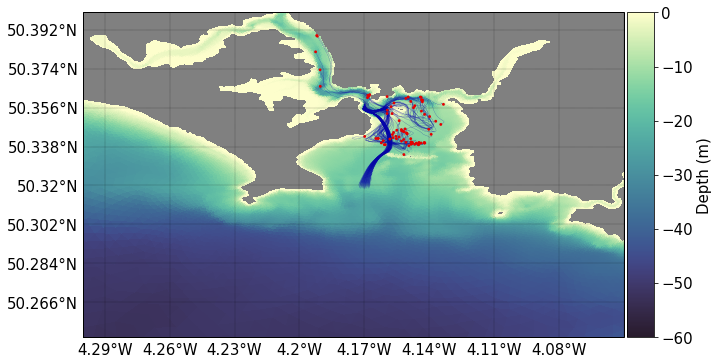

In [6]:
import warnings
import numpy as np
from netCDF4 import Dataset
from datetime import timedelta
import cartopy.crs as ccrs

from PyFVCOM.coordinate import utm_from_lonlat, lonlat_from_utm

from pylag.processing.ncview import Viewer
from pylag.processing.plot import FVCOMPlotter
from pylag.processing.plot import create_figure, colourmap

warnings.filterwarnings('ignore')

# Read in the bathymetry
ds = Dataset(grid_metrics_file_name, 'r')
bathy = -ds.variables['h'][:]
ds.close()
del(ds)

file_name = '{}/output/pylag_1.nc'.format(simulation_dir)

# Time of flight (-ve)
time_of_flight = timedelta(hours=-15)

# Font size for plotting
font_size = 15

# Colour map for plotting
cmap = colourmap('h_r')

# Plot extents
extents = np.array([-4.3, -4.05, 50.25, 50.4], dtype=float)

fig, ax = create_figure(figure_size=(26., 26.), projection=ccrs.PlateCarree(), font_size=font_size, bg_color='gray')

# Configure plotter
plotter = FVCOMPlotter(grid_metrics_file_name,
                       geographic_coords=True,
                       font_size=font_size)


# Plot the bathymetry again. We'll overlay pathlines on top of this.
plotter.plot_field(ax, bathy, extents=extents, add_colour_bar=True, cb_label='Depth (m)',
                   vmin=-60., vmax=0., cmap=cmap)

# Dataset holding particle positions
viewer = Viewer(file_name, time_rounding=900)

# Get time index
date = viewer.date[0] + time_of_flight
time_index = viewer.date.tolist().index(date)

# Convert positions into lons/lats
lons, lats = lonlat_from_utm(viewer('x')[time_index, :].squeeze(),
                             viewer('y')[time_index, :].squeeze(), zone='30N')

# Plot particle final positions
ax, scatter = plotter.scatter(ax, lons, lats, s=8, color='#e50000', edgecolors='none')

# Convert all pathline coordinates into lons/lats
lons_paths, lats_paths = lonlat_from_utm(viewer('x')[:time_index+1, :].squeeze(),
                                         viewer('y')[:time_index+1, :].squeeze(), zone='30N')

# Add path lines
ax, lines = plotter.plot_lines(ax, lons_paths, lats_paths, linewidth=0.15, alpha=1, color='#0504aa')

In the image, it can be seen that particles at the release site originated from within Plymouth Sound and up the River Tamar.